In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import matplotlib.pyplot as plt

from datetime import datetime, timedelta, date
from mechafil import data
import pandas as pd
import numpy as np

import copy

from agentfil.filecoin_model import FilecoinModel, solve_geometric, distribute_agent_power_geometric_series
from agentfil.sp_agent_backtest import SPAgent_Backtest
from agentfil import constants
from mechafil import minting, sim

In [3]:
# we are backtesting, so we fast-forward n months from network start.  That is the start
# of the simulation. Data before the start of simulation is used to seed all of the forecasting.
# To backtest, we take the following strategy. We take the remainder of data from: 
# simulation_start to today-1, and seed the agents power behavior with that data. Power behavior
# means the decisions agents make about onboarding/renewing/terminating/scheduled-expire power.
# The remainder of the agent-based simulation computes all downstream metrics,
# including minting and circulating supply.
# From a nomenclature perspective, backtesting isn't exactly correct since we force agent power
# decisions. However, because all downstream metrics depend on network power, we backtest the 
# remainder of the metrics and if they are correct, then we can be reasonably confident about 
# the implementation.

data_start_date = date(2021, 3, 15)
n_months_offset = 12
simulation_start_date = data_start_date + timedelta(days=n_months_offset*30)
end_date = datetime.today().date() - timedelta(days=1)

num_agents = 20

print(simulation_start_date, end_date)

2022-03-10 2023-01-26


In [4]:
# get historical stats for comparison and seeding the backtesting agents
historical_stats = data.get_historical_network_stats(data_start_date, end_date, end_date)
scheduled_df = data.query_sector_expirations(data_start_date, end_date)
historical_stats['date'] = pd.to_datetime(historical_stats['date']).dt.date
scheduled_df['date'] = scheduled_df['date'].dt.date
merged_df = historical_stats.merge(scheduled_df, on='date', how='inner')

In [5]:
# subset to the forecasts to properly setup inputs
merged_df_subset = merged_df[(merged_df['date'] >= simulation_start_date) & (merged_df['date'] <= end_date)]

# compute rb-onboard-power, fil+rate, and renewal_rate for mechaFIL inputs
rbp = merged_df_subset['day_onboarded_rb_power_pib']
rr = merged_df_subset["extended_rb"] / merged_df_subset["total_rb"]
fpr = merged_df_subset["extended_qa"] / (merged_df_subset["extended_rb"] + merged_df_subset['extended_qa'])

rbp = rbp.values
rr = rr.values
fpr = fpr.values

mechafil_start_date = constants.NETWORK_DATA_START
mechafil_current_date = simulation_start_date
mechafil_forecast_length = (end_date-simulation_start_date).days

# compute mechaFIL predictions to compare with agentFIL to better determine
# if implementation/porting of code is correct
mechafil_df = sim.run_simple_sim(
    mechafil_start_date,
    mechafil_current_date,
    mechafil_forecast_length,
    rr,
    rbp,
    fpr,
    360,
    qap_method = 'basic' # can be set to tunable or basic
                         # see: https://hackmd.io/O6HmAb--SgmxkjLWSpbN_A?view
)

/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [6]:
agent_types = [SPAgent_Backtest] * num_agents
filecoin_model1 = FilecoinModel(num_agents, simulation_start_date, end_date, agent_types, 
                                compute_cs_from_networkdatastart=True, use_historical_gas=False)
# filecoin_model2 = FilecoinModel(num_agents, simulation_start_date, end_date, agent_types, 
#                                 compute_cs_from_networkdatastart=True, use_historical_gas=True)
# filecoin_model3 = FilecoinModel(num_agents, simulation_start_date, end_date, agent_types, 
#                                 compute_cs_from_networkdatastart=False, use_historical_gas=False)

/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


Fast forwarding power to simulation start date... 2022-03-10
Computing Scheduled Expirations from:  2022-03-10  to:  2023-01-25


In [7]:
backtest_seed_df = merged_df[merged_df['date'] >= simulation_start_date]
backtest_seed_power_df = backtest_seed_df[
    [
        'date',
        'day_onboarded_rb_power_pib', 'day_onboarded_qa_power_pib',
        'extended_rb', 'extended_qa',
        'total_rb', 'total_qa',
        'terminated_rb', 'terminated_qa'
    ]
]
backtest_seed_power_df = backtest_seed_power_df.rename(
    columns={
        'extended_rb': 'extended_rb_pib',
        'extended_qa': 'extended_qa_pib',
        'total_rb': 'sched_expire_rb_pib',
        'total_qa': 'sched_expire_qa_pib',
        'terminated_rb': 'terminated_rb_pib',
        'terminated_qa': 'terminated_qa_pib',
    }
)

# add future onboard/renew/terminate/expire into the backtest agents
agent_power_distributions = distribute_agent_power_geometric_series(num_agents)
for ii in range(num_agents):
    agent_power_pct = agent_power_distributions[ii]
    seed_df = backtest_seed_power_df.drop('date', axis=1) * agent_power_pct
    seed_df['date'] = backtest_seed_power_df['date']

    filecoin_model1.agents[ii]['agent'].seed_backtest(seed_df)
#     filecoin_model2.agents[ii]['agent'].seed_backtest(seed_df)
#     filecoin_model3.agents[ii]['agent'].seed_backtest(seed_df)

In [8]:
# run the simulation and finish populating the filecoin_df in the filecoin_model
sim_len = (end_date - simulation_start_date).days
for ii in range(sim_len):
    filecoin_model1.step()
#     filecoin_model2.step()
#     filecoin_model3.step()

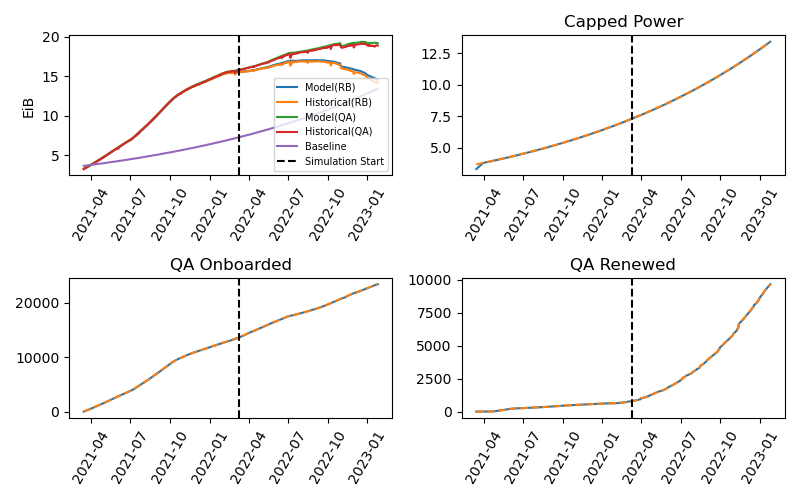

In [9]:
# compare the two
model_df = filecoin_model1.filecoin_df

plt.figure(figsize=(8,5))
plt.subplot(2,2,1)
plt.plot(model_df['date'], model_df['total_raw_power_eib'], label='Model(RB)')
plt.plot(merged_df['date'], merged_df['total_raw_power_eib'], label='Historical(RB)')
plt.plot(model_df['date'], model_df['total_qa_power_eib'], label='Model(QA)')
plt.plot(merged_df['date'], merged_df['total_qa_power_eib'], label='Historical(QA)')
plt.plot(model_df['date'], model_df['network_baseline'] / 2**60, label='Baseline')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.legend(fontsize=7)
plt.xticks(rotation=60)
plt.ylabel('EiB')

plt.subplot(2,2,2)
plt.plot(model_df['date'], model_df['capped_power'] / 2**60, label='Capped Power')
plt.plot(model_df['date'], model_df['network_baseline'] / 2**60, label='Baseline', linestyle='--')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.xticks(rotation=60)
plt.title('Capped Power')

plt.subplot(2,2,3)
plt.plot(model_df['date'], model_df['day_onboarded_qap_pib'].cumsum(), label='QA')
plt.plot(merged_df['date'], merged_df['day_onboarded_qa_power_pib'].cumsum(), label='Historical(QA)', linestyle='--')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.xticks(rotation=60)
plt.title('QA Onboarded')

plt.subplot(2,2,4)
plt.plot(model_df['date'], model_df['day_renewed_qap_pib'].cumsum(), label='QA')
plt.plot(merged_df['date'], merged_df['day_renewed_qa_power_pib'].cumsum(), label='Historical(QA)', linestyle='--')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.xticks(rotation=60)
plt.title('QA Renewed')

plt.tight_layout()

plt.show()

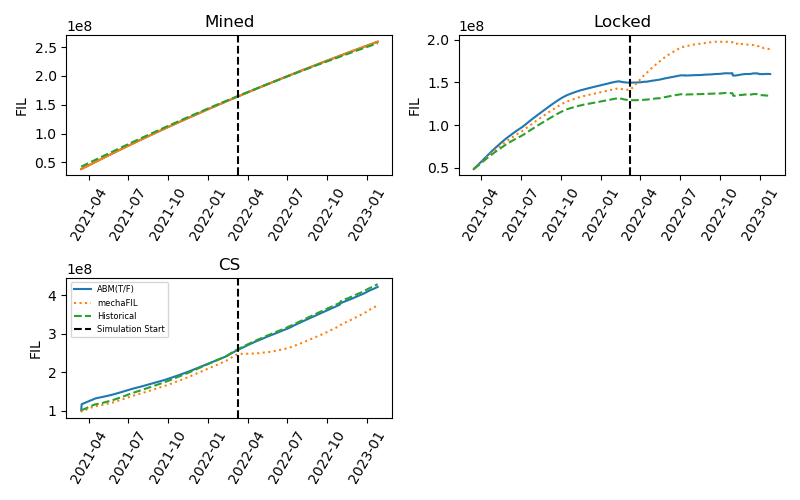

In [10]:
plt.figure(figsize=(8,5))

plt.subplot(2,2,1)
plt.plot(filecoin_model1.filecoin_df['date'], filecoin_model1.filecoin_df['cum_network_reward'], label='ABM(T/F)')
# plt.plot(filecoin_model2.filecoin_df['date'], filecoin_model2.filecoin_df['cum_network_reward'], label='ABM(T/T)')
# plt.plot(filecoin_model3.filecoin_df['date'], filecoin_model3.filecoin_df['cum_network_reward'], label='ABM(F)')
plt.plot(mechafil_df['date'], mechafil_df['cum_network_reward'], label='mechaFIL')
plt.plot(merged_df['date'], merged_df['mined_fil'], label='Historical', linestyle='--')
# plt.plot(merged_df['date'], merged_df['mined_fil']-model_df['cum_network_reward'], label='Historical', linestyle='--')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.xticks(rotation=60)
plt.ylabel('FIL')
plt.title('Mined')

plt.subplot(2,2,2)
plt.plot(filecoin_model1.filecoin_df['date'], filecoin_model1.filecoin_df['network_locked'], label='ABM(T/F)')
# plt.plot(filecoin_model2.filecoin_df['date'], filecoin_model2.filecoin_df['network_locked'], label='ABM(T/T)')
# plt.plot(filecoin_model3.filecoin_df['date'], filecoin_model3.filecoin_df['network_locked'], label='ABM(F)')
plt.plot(mechafil_df['date'], mechafil_df['network_locked'], label='mechaFIL', linestyle=':')
plt.plot(merged_df['date'], merged_df['locked_fil'], label='Historical', linestyle='--')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
# plt.legend(fontsize=7)
plt.xticks(rotation=60)
plt.ylabel('FIL')
plt.title('Locked')

plt.subplot(2,2,3)
plt.plot(filecoin_model1.filecoin_df['date'], filecoin_model1.filecoin_df['circ_supply'], label='ABM(T/F)')
# plt.plot(filecoin_model2.filecoin_df['date'], filecoin_model2.filecoin_df['circ_supply'], label='ABM(T/T)')
# plt.plot(filecoin_model3.filecoin_df['date'], filecoin_model3.filecoin_df['circ_supply'], label='ABM(F)')
plt.plot(mechafil_df['date'], mechafil_df['circ_supply'], label='mechaFIL', linestyle=':')
plt.plot(merged_df['date'], merged_df['circulating_fil'], label='Historical', linestyle='--')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.legend(fontsize=6)
plt.xticks(rotation=60)
plt.ylabel('FIL')
plt.title('CS')


plt.tight_layout()